### Re-write galsim in Scarlet

In [1]:
# Import packages
%reload_ext autoreload
%autoreload 2

import warnings
warnings.filterwarnings('ignore')

In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
import scarlet

import kuaizi as kz
from kuaizi.display import display_single, display_rgb, SEG_CMAP
from kuaizi.detection import Data
from kuaizi.utils import padding_PSF

import unagi

import astropy.units as u
from astropy import wcs
from astropy.io import fits
from astropy.table import Table, Column, vstack
from astropy.coordinates import SkyCoord, match_coordinates_sky
from astropy.convolution import convolve, Gaussian2DKernel


Bad key savefig.frameon in file /projects/HSC/LSST/stack_20200903/conda/miniconda3-py37_4.8.2/envs/lsst-scipipe-cb4e2dc/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle, line 421 ('savefig.frameon : True')
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.3.4/matplotlibrc.template
or from the matplotlib source distribution

Bad key verbose.level in file /projects/HSC/LSST/stack_20200903/conda/miniconda3-py37_4.8.2/envs/lsst-scipipe-cb4e2dc/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle, line 472 ('verbose.level  : silent      # one of silent, helpful, debug, debug-annoying')
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.3.4/matplotlibrc.template
or from the matplotlib source distribution

Bad key verbose.fileo in file /projects/HSC/LSST/stack_20200903/conda/miniconda3-py37_4.8.2/envs/lsst-scipipe-cb4e2dc

In [3]:
import galsim
from galsim import Angle, radians
from kuaizi.mock import MockGal

In [28]:
from scarlet.profile import SpergelProfile

$$ \Sigma(r) \sim \frac{1}{\Gamma(\nu + 1)}\left(\frac{c_\nu r}{2r_0}\right)^{\nu} K_\nu\left(\frac{c_\nu r}{r_0}\right)$$

In [92]:
david = SpergelProfile(0.5, 10, 0., 0., boxsize=201)
# david = SpergelProfile([1, 10, -0.1, 0.5], boxsize=201)

0.5
10
0.0
0.0


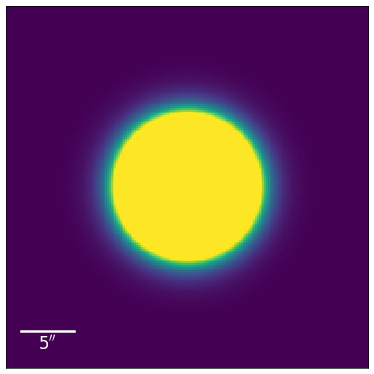

In [93]:
display_single(david.get_model()[0]);

In [94]:
david.get_model().sum()

Parameter(1.00016437)

In [19]:
david._cnu(0.5)

1.688961669811074

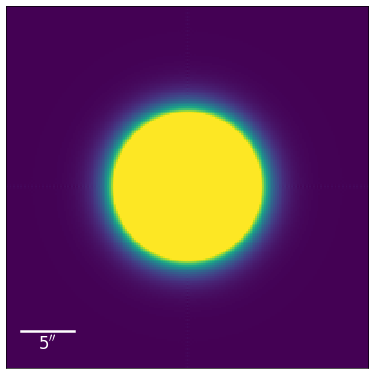

In [96]:
spergel2d = galsim.spergel.Spergel(nu=0.5, half_light_radius=10, flux=1).shear(g1=0, g2=0)
#.shear(g1=-0.1, g2=0.5)
gal_img = spergel2d.drawImage(method='fft', 
                    scale=1, 
                    nx=201, 
                    ny=201, 
                    offset=(0, 0))
im1 = gal_img.array
# im1 /= im1.sum()
display_single(im1);

In [100]:
np.abs(david.get_model()[0] - im1).sum()

Parameter(0.00778304)

In [73]:
shear = galsim.shear.Shear(g1=-0.1, g2=0.5)
# shear = galsim.shear.Shear(g1=0, g2=0)

In [74]:
10 / np.sqrt(shear.q)

17.55225365802012

In [79]:
import sep
a = 10 / np.sqrt(shear.q)
sep.sum_ellipse(im, [100], [100], [a], [a * shear.q], [shear.beta.rad])

(array([0.49874433]), array([0.]), array([0], dtype=int16))

In [54]:
f_cv = david._cnu

In [76]:
x, y = np.meshgrid(np.arange(201), np.arange(201))
x_0, y_0 = 100.001, 100.001
im = evaluate_shear(x, y, 1, 10, 1.5, x_0, y_0, -0.1, 0.5)
im /= im.sum()

In [77]:
np.abs(im - im1).sum()

0.0019201246481286335

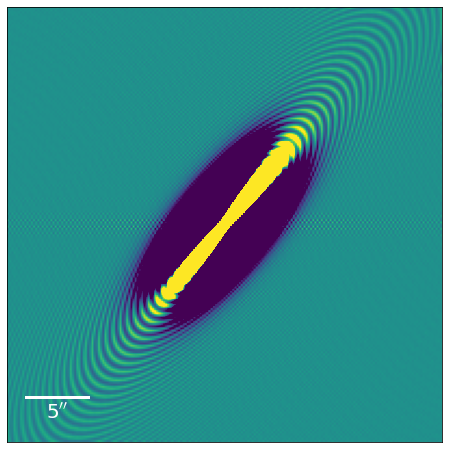

In [78]:
display_single(im - im1);

In [48]:
from scipy.special import kv, gamma
from scipy.interpolate import interp1d, UnivariateSpline
from scipy.optimize import root_scalar, fsolve

In [49]:
f_v = david._f_nu

In [51]:
def evaluate_shear(x, y, amplitude, r_eff, nu, x_0, y_0, g1, g2):
    """Two dimensional Sersic profile function."""
    cv = f_cv(nu)
    g = np.sqrt(g1**2 + g2**2)
    shear_matrix = np.array([[1 + g1, g2], [g2, 1 - g1]]) / np.sqrt(1 - g**2)
    
    pos = np.vstack([(x - x_0).ravel(), (y - y_0).ravel()])
    pos = (pos.T @ np.linalg.inv(shear_matrix)).T
    
    x, y = pos[0].reshape(x.shape), pos[1].reshape(y.shape)
    
    z = np.sqrt((x / r_eff) ** 2 + (y / r_eff) ** 2)
    
    return amplitude * f_v(cv * z, nu)

In [52]:
def evaluate_shear_new(x, y, amplitude, r_eff, nu, x_0, y_0, g1, g2):
    """Two dimensional Sersic profile function."""
    cv = f_cv(nu)
    g = np.sqrt(g1**2 + g2**2)
    shear_matrix = np.array([[1 + g1, g2], [g2, 1 - g1]]) / np.sqrt(1 - g**2)
    shear_matrix = np.linalg.inv(shear_matrix)
    
    x_ = shear_matrix[0, 0] * (x - x_0) + shear_matrix[0, 1] * (y - y_0)
    y_ = shear_matrix[1, 0] * (x - x_0) + shear_matrix[1, 1] * (y - y_0)
    
    z = np.sqrt((x_ / r_eff) ** 2 + (y_ / r_eff) ** 2)
    
    return amplitude * f_v(cv * z, nu)

In [199]:
def gaussian(X, sigma):
    return np.exp(-(X ** 2) / (2 * sigma ** 2))

In [213]:
np.meshgrid(david._X, david._Y)

[array([[-100,  -99,  -98, ...,   98,   99,  100],
        [-100,  -99,  -98, ...,   98,   99,  100],
        [-100,  -99,  -98, ...,   98,   99,  100],
        ...,
        [-100,  -99,  -98, ...,   98,   99,  100],
        [-100,  -99,  -98, ...,   98,   99,  100],
        [-100,  -99,  -98, ...,   98,   99,  100]]),
 array([[-100, -100, -100, ..., -100, -100, -100],
        [ -99,  -99,  -99, ...,  -99,  -99,  -99],
        [ -98,  -98,  -98, ...,  -98,  -98,  -98],
        ...,
        [  98,   98,   98, ...,   98,   98,   98],
        [  99,   99,   99, ...,   99,   99,   99],
        [ 100,  100,  100, ...,  100,  100,  100]])]

In [216]:
np.broadcast_arrays(david._X[None, :], david._Y[:, None])

[array([[-100,  -99,  -98, ...,   98,   99,  100],
        [-100,  -99,  -98, ...,   98,   99,  100],
        [-100,  -99,  -98, ...,   98,   99,  100],
        ...,
        [-100,  -99,  -98, ...,   98,   99,  100],
        [-100,  -99,  -98, ...,   98,   99,  100],
        [-100,  -99,  -98, ...,   98,   99,  100]]),
 array([[-100, -100, -100, ..., -100, -100, -100],
        [ -99,  -99,  -99, ...,  -99,  -99,  -99],
        [ -98,  -98,  -98, ...,  -98,  -98,  -98],
        ...,
        [  98,   98,   98, ...,   98,   98,   98],
        [  99,   99,   99, ...,   99,   99,   99],
        [ 100,  100,  100, ...,  100,  100,  100]])]

In [202]:
img = gaussian(np.abs(david._X), 10)[:, None] * gaussian(np.abs(david._Y), 10)[None, :]

In [211]:
img = f_v(np.abs(david._X / 10), 0.5)[:, None] * f_v(np.abs(david._Y / 10), 0.5)[None, :]

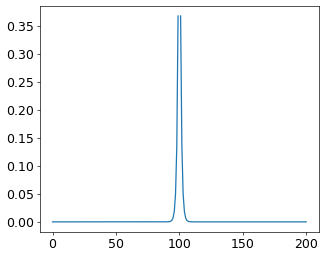

In [207]:
plt.plot(f_v(np.abs(david._X), 0.5))

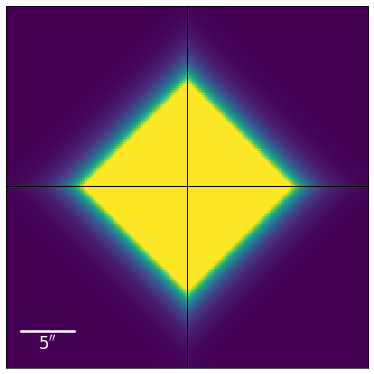

In [212]:
display_single(img);

In [194]:
david._X[:, None] * david._Y[None, :]

array([[ 10000,   9900,   9800, ...,  -9800,  -9900, -10000],
       [  9900,   9801,   9702, ...,  -9702,  -9801,  -9900],
       [  9800,   9702,   9604, ...,  -9604,  -9702,  -9800],
       ...,
       [ -9800,  -9702,  -9604, ...,   9604,   9702,   9800],
       [ -9900,  -9801,  -9702, ...,   9702,   9801,   9900],
       [-10000,  -9900,  -9800, ...,   9800,   9900,  10000]])

In [53]:
x, y = np.meshgrid(np.arange(100), np.arange(100))
x_0, y_0 = 49.5, 50
im = evaluate_shear(x, y, 1, 5, 1, x_0, y_0, -0.1, 0.5)

In [243]:
x, y = np.meshgrid(np.arange(100), np.arange(100))
x_0, y_0 = 49.5, 50
im = evaluate_shear_new(x, y, 1, 5, -0.6, x_0, y_0, -0.1, 0.5)

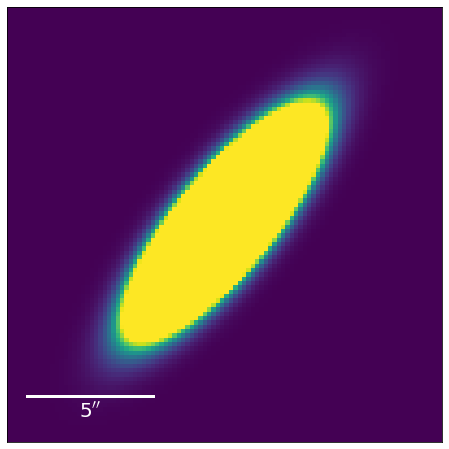

In [302]:
display_single(im);

In [80]:
from scarlet.profile import SpergelProfile

In [105]:
david = SpergelProfile([-0.6, 10, -0.1, 0.1], boxsize=201)

In [106]:
im = david.get_model()

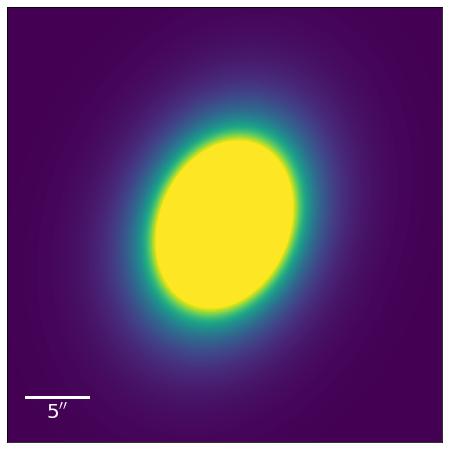

In [107]:
display_single(im[0]);

In [4]:
from kuaizi.fit import ScarletFitter, fitting_obs_tigress

In [5]:
env_dict = {'project': 'HSC', 'name': 'LSBG', 'data_dir': '/scratch/gpfs/jiaxuanl/Data'}
kz.utils.set_env(**env_dict)
kz.utils.set_matplotlib(style='default', usetex=False)

In [6]:
lsbg_cat = Table.read('./Catalog/mock_sample/mock_obj_cat_0_2000.fits')
lsbg = lsbg_cat[1498] # 12 # 69

In [7]:
prefix = 'LSBG'
channels = 'griz'
index = lsbg['viz-id']

bright = (lsbg['mag_auto_i'] < 17.5)
print('Bright =', bright)

lsbg_coord = SkyCoord(ra=lsbg['ra'], dec=lsbg['dec'], unit='deg')
cutout = [fits.open(f"{lsbg['prefix']}_{band}.fits") for band in channels]
psf_list = [fits.open(f"{lsbg['prefix']}_{band}_psf.fits") for band in channels]

images = np.array([hdu[1].data for hdu in cutout])
# note: all bands share the same WCS here, but not necessarily true.
w = wcs.WCS(cutout[0][1].header)
weights = 1.0 / np.array([hdu[3].data for hdu in cutout])
weights[np.isinf(weights)] = 0.0
psf_pad = padding_PSF(psf_list)  # Padding PSF cutouts from HSC
psfs = scarlet.ImagePSF(np.array(psf_pad))
# saturation mask and interpolation mask from HSC S18A
sat_mask = np.array([sum(unagi.mask.Mask(
    hdu[2].data, data_release='s18a').extract(['INTRP', 'SAT'])) for hdu in cutout])
data = Data(images=images, weights=weights, masks=sat_mask,
            wcs=w, psfs=psfs, channels=channels)

Bright = False


In [8]:
fitter = ScarletFitter(method='wavelet', tigress=True, bright=bright,
                       starlet_thresh=0.3, min_grad=-0.2,
                       monotonic=True, bkg=True,
                       variance=0.015**2, 
                       scales=[0, 1, 2, 3, 4],
                       model_dir='./Model/mock_sample/',
                       figure_dir='./Figure/mock_sample',
                       log_dir='./log/mock_sample',
                       prefix='mock', 
                       index=lsbg['viz-id'], 
                       show_figure=True)
fitter.load_data(data, lsbg_coord)

    Query GAIA stars...
    Taking Gaia catalogs stored in `Tigress`
    8 stars from Gaia are masked!
    Detected 278 objects
    8 stars from Gaia are masked!
    Detected 228 objects
    Detected 141 objects


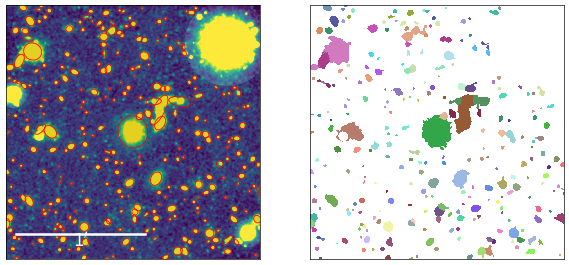

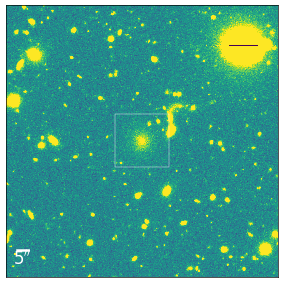

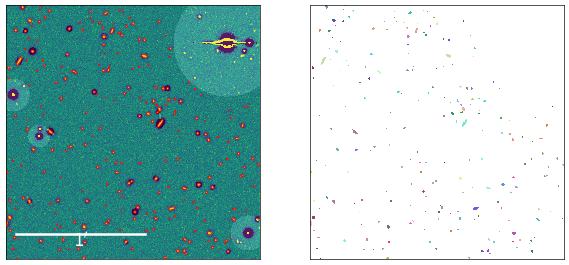

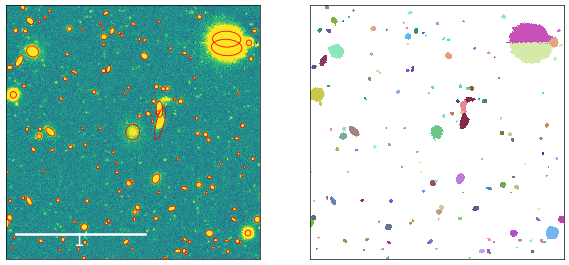

In [9]:
fitter._first_gaia_search()
# Set the weights of saturated star centers to zero
# In order to make the box size estimation more accurate.
temp = np.copy(fitter.data.masks)
for i in range(len(fitter.data.channels)):
    temp[i][~fitter.msk_star_ori.astype(bool)] = 0
    fitter.data.weights[i][temp[i].astype(bool)] = 0.0
    
# Replace the vanilla detection with a convolved vanilla detection
first_dblend_cont = 0.07 if max(
    fitter.data.images.shape) * fitter.pixel_scale > 200 else 0.006

if fitter.method == 'wavelet':
    first_dblend_cont = 0.07 if max(
    fitter.data.images.shape) * fitter.pixel_scale > 200 else 0.002
        
fitter._first_detection(first_dblend_cont)
fitter._estimate_box(fitter.cen_obj)
fitter._mask_stars_outside_box()
fitter._cpct_obj_detection()
fitter._big_obj_detection()
fitter._merge_catalogs()
fitter._construct_obs_frames()

In [10]:
from scarlet.source import SpergelSource, SingleExtendedSource
src = fitter.cen_obj
## We first initialize an ExtendedSource to guess the initial parameters
new_source = SingleExtendedSource(
              fitter.model_frame, 
              (src['ra'], src['dec']),
              fitter.observation,
#               fitter._conv_observation,
              satu_mask=fitter.data.masks,
              thresh=0.1, 
              shifting=True, 
              min_grad=0.05)

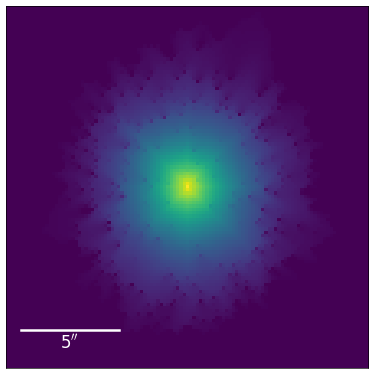

In [11]:
display_single(new_source.morphology, scale='linear');

In [12]:
from scarlet.measure import g1g2, flux_radius

In [13]:
morph = new_source.morphology
SED = np.array(new_source.spectrum * new_source.morphology.sum())
g1, g2 = g1g2(np.array(morph))
rhalf = flux_radius(np.array(morph), 0.45)
nu = np.array([0.5])

In [17]:
david = SpergelSource(
    fitter.model_frame, 
    (src['ra'], src['dec']),
    nu, rhalf, np.array((g1[0], g2[0])),
    fitter._conv_observation, 
    SED=SED)

In [73]:
new_source.spectrum * new_source.morphology.sum()

Parameter([280.91106466, 384.11627782, 410.52821912, 496.06393432])

In [19]:
david.parameters

(Parameter([280.91106466, 384.11627782, 410.52821912, 496.06393432]),
 Parameter([357.63906368, 357.06270736]),
 Parameter([[0.5]]),
 Parameter([[16.37464866]]),
 Parameter([-0.05478731,  0.0038191 ]))

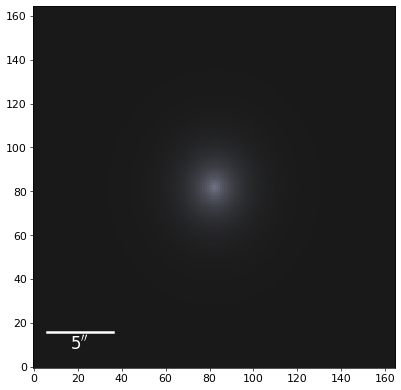

In [18]:
display_rgb(david.get_model());

In [20]:
fitter._sources = [david]
print(fitter._sources[0].bbox)
fitter.blend = scarlet.Blend(fitter._sources, fitter.observation)

<Box shape=(4, 165, 165), origin=(0, 276, 275)>


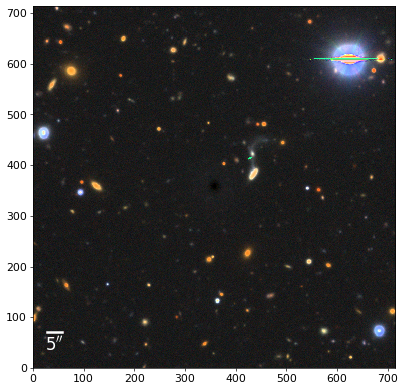

In [21]:
display_rgb(fitter.data.images - fitter.blend.get_model());

[<AxesSubplot:title={'center':'Data'}>,
 <AxesSubplot:title={'center':'Model'}>,
 <AxesSubplot:title={'center':'Residual'}>]

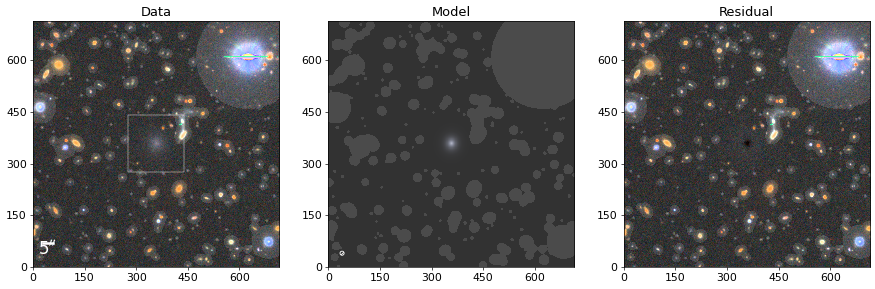

In [22]:
kz.display.display_scarlet_model(
    fitter.blend,
    #show_ind=[0],
    #zoomin_size=50,
    minimum=-0.2,
    stretch=0.9,
    add_boxes=True,
    channels='griz',
    show_mask=False,
    show_mark=False, 
    show_loss=False)

In [26]:
fitter.blend.fit(200, 1e-6)

(48, 2202964.6032242896)

[<AxesSubplot:title={'center':'Data'}>,
 <AxesSubplot:title={'center':'Model'}>,
 <AxesSubplot:title={'center':'Residual'}>]

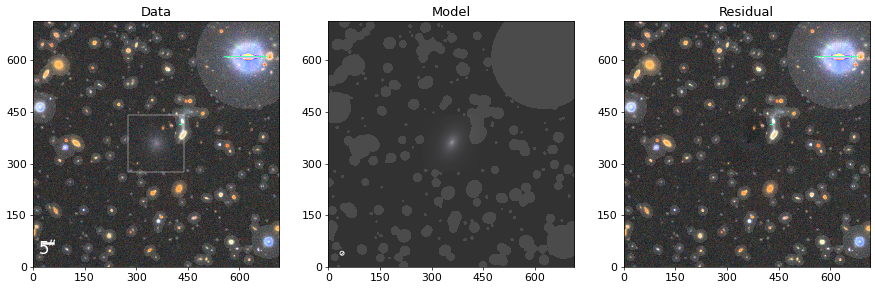

In [27]:
kz.display.display_scarlet_model(
    fitter.blend,
    #show_ind=[0],
    #zoomin_size=50,
    minimum=-0.2,
    stretch=0.9,
    add_boxes=True,
    channels='griz',
    show_mask=False,
    show_mark=False, 
    show_loss=False)